
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#1663BE;
           font-size:110%;
           font-family:Calibri;
           letter-spacing:0.5px">

<p style="padding: 0.015px;
              color:black;">  

#  Problem Statement

<p style="padding: 0.015px;
              color:white;">
</p>
</div>

The main objective of the face detection model is to detect the face of individuals and conclude whether they are wearing masks or not at that particular moment when they are captured in the image.  we increase the complexity of mask detection using image segmentation and prediction tools.

In [35]:
# import necessary library
import pandas as pd
import numpy as np
import os
import cv2
import shutil
import numpy as np
import argparse
import zipfile
from matplotlib import pyplot
from matplotlib.image import imread
from timeit import default_timer as timer
start = timer()
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [2]:
# Part 1 - Building the CNN

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import tensorflow.keras

In [3]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Extracts files under /tmp folder

zip_ref = zipfile.ZipFile('/content/drive/My Drive/MASK.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp')
zip_ref.close()

In [8]:
#check lenght of file
len(os.listdir('/tmp/data/with_mask'))

3725

In [9]:
#check lenght of file
len(os.listdir('/tmp/data/without_mask'))

3828

In [10]:

path='/tmp'
path_to_data='/tmp/data'
path_to_test_data='/tmp/test'
def get_files_from_folder(path):
  files = os.listdir(path)
  return np.asarray(files)
# get dirs
for r, d, f in os.walk(path_to_data):
  for dirs in d:
    print(dirs)


_, dirs, _ = next(os.walk(path_to_data))

# calculates how many train data per class
data_counter_per_class = np.zeros((len(dirs)))
print(len(dirs))
for i in range(len(dirs)):
  path = os.path.join(path_to_data, dirs[i])
  print(path)

  files = get_files_from_folder(path)
  print(len(files))
  data_counter_per_class[i] = len(files)
  print(data_counter_per_class[i])
  test_counter = np.round(data_counter_per_class * (1 - 0.8))
  print(test_counter)
# transfers files
for i in range(len(dirs)):
  path_to_original = os.path.join(path_to_data, dirs[i])
  path_to_save = os.path.join(path_to_test_data, dirs[i])
  print(path_to_original)
  print(path_to_save)
  if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
  files = get_files_from_folder(path_to_original)
  for j in range(int(test_counter[i])):
    dst = os.path.join(path_to_save, files[j])
    src = os.path.join(path_to_original, files[j])
    shutil.move(src, dst)

with_mask
without_mask
2
/tmp/data/with_mask
3725
3725.0
[745.   0.]
/tmp/data/without_mask
3828
3828.0
[745. 766.]
/tmp/data/with_mask
/tmp/test/with_mask
/tmp/data/without_mask
/tmp/test/without_mask


In [16]:
#check lenght of file after train and test
print("Train file withmask",len(os.listdir('/tmp/data/with_mask')))
print("Test file withmask:",len(os.listdir('/tmp/test/with_mask')))
print("Train file without mask",len(os.listdir('/tmp/data/without_mask')))
print("Test file without mask:",len(os.listdir('/tmp/test/without_mask')))

Train file withmask 2980
Test file withmask: 745
Train file without mask 3062
Test file without mask: 766


In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows you to:

configure random transformations and normalization operations to be done on your image data during training
instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [17]:
# Fitting the CNN to the images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

Example: obtaining a labeled dataset from image files on disk

Supposed you have image files sorted by class in different folders, like                                                                                                        this:                                                                             
                                                  main_directory/

...class_a/

......a_image_1.jpg

......a_image_2.jpg



...class_b/

......b_image_1.jpg

......b_image_2.jpg

train_generator = train_datagen.flow_from_directory

(
  
      directory=r"./train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

The directory must be set to the path where your ‘n’ classes of folders are present.

The target_size is the size of your input images, every image will be resized to this size.

color_mode: if the image is either black and white or grayscale set “grayscale” or if the image has three color channels, set “rgb”.

batch_size: No. of images to be yielded from the generator per batch.

class_mode: Set “binary” if you have only two classes to predict, if not set to“categorical”, in case if you’re developing an Autoencoder system, both input and the output would probably be the same image, for this case set to “input”.

shuffle: Set True if you want to shuffle the order of the image that is being yielded, else set False.
seed: Random seed for applying random image augmentation and shuffling the order of the image.

In [18]:
#Train image size 64 and bactch size 32 with binary classification
training_set = train_datagen.flow_from_directory('/tmp/data',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 6042 images belonging to 2 classes.


In [19]:
#Test image size 64 and bactch size 32 with binary classification
test_set = test_datagen.flow_from_directory('/tmp/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 1511 images belonging to 2 classes.


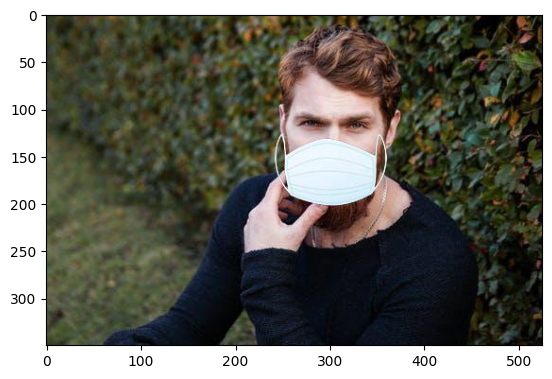

In [23]:
# plot withmask vs without mask dataset

image = imread("/tmp/data/with_mask/with_mask_1.jpg")
	# plot raw pixel data
pyplot.imshow(image)
# show the figure
pyplot.show()

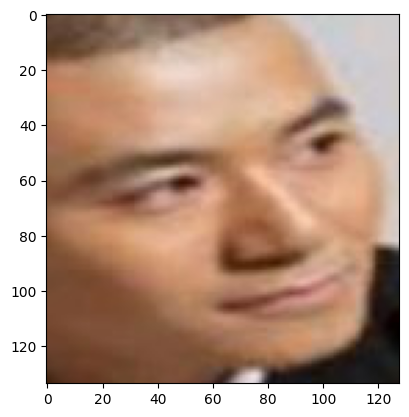

In [24]:
# plot withmask vs witoth mask dataset
image = imread("/tmp/data/without_mask/without_mask_7.jpg")
	# plot raw pixel data
pyplot.imshow(image)
# show the figure
pyplot.show()

In [25]:
# Initialising the CNN
classifier = Sequential()

In [26]:
# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [27]:
# Step 3 - Flattening
classifier.add(Flatten())

In [28]:
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

In [30]:
# Compiling the CNN use optimizer as adam and loss as binary_crossentropy
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [32]:

history =classifier.fit_generator(training_set,
                         epochs = 10,
                         validation_data = test_set
                         );

end = timer()
print('Training Completed!')
print("Time Elapsed in seconds",  (end - start))

Epoch 1/10


<ipython-input-32-c0635ff84ece>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =classifier.fit_generator(training_set,


 57/189 [========>.....................] - ETA: 14s - loss: 0.6062 - accuracy: 0.6595

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - 40s 149ms/step - loss: 0.4077 - accuracy: 0.8064 - val_loss: 0.2786 - val_accuracy: 0.8934
Epoch 2/10
189/189 [==============================] - 36s 191ms/step - loss: 0.2637 - accuracy: 0.8956 - val_loss: 0.2434 - val_accuracy: 0.9067
Epoch 3/10
189/189 [==============================] - 31s 162ms/step - loss: 0.2305 - accuracy: 0.9062 - val_loss: 0.2153 - val_accuracy: 0.9173
Epoch 4/10
189/189 [==============================] - 32s 171ms/step - loss: 0.2069 - accuracy: 0.9201 - val_loss: 0.2122 - val_accuracy: 0.9173
Epoch 5/10
189/189 [==============================] - 32s 170ms/step - loss: 0.1901 - accuracy: 0.9227 - val_loss: 0.1904 - val_accuracy: 0.9265
Epoch 6/10
189/189 [==============================] - 32s 171ms/step - loss: 0.1717 - accuracy: 0.9336 - val_loss: 0.1809 - val_accuracy: 0.9345
Epoch 7/10
189/189 [==============================] - 30s 161ms/step - loss: 0.1609 - accuracy: 0.9351 - val_loss: 0.1870 - val_accuracy: 0.9

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


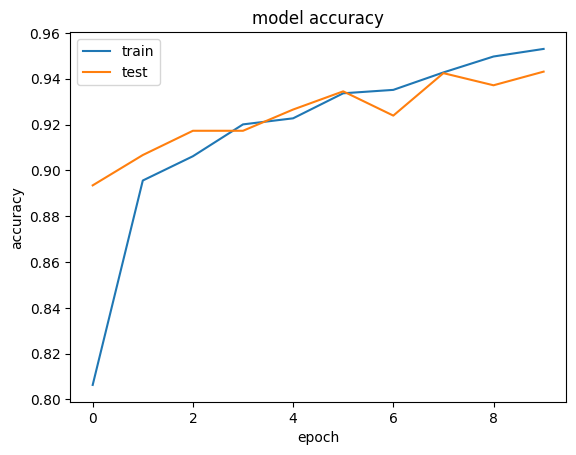

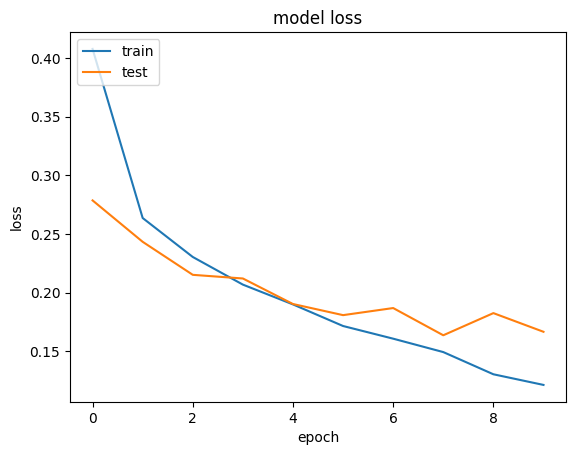

In [36]:

# list all data in history plot with accuracy and val_accuracy
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')



plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
# save model and architecture to single file
classifier.save('/content/drive/My Drive/FDPCNN1.h5')
classifier.summary()

print("Saved model to disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8

In [38]:
# Loading saved model from Drive.

model = load_model('/content/drive/My Drive/FDPCNN1.h5')
print("Model is Loaded")
model.summary()

Model is Loaded
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)

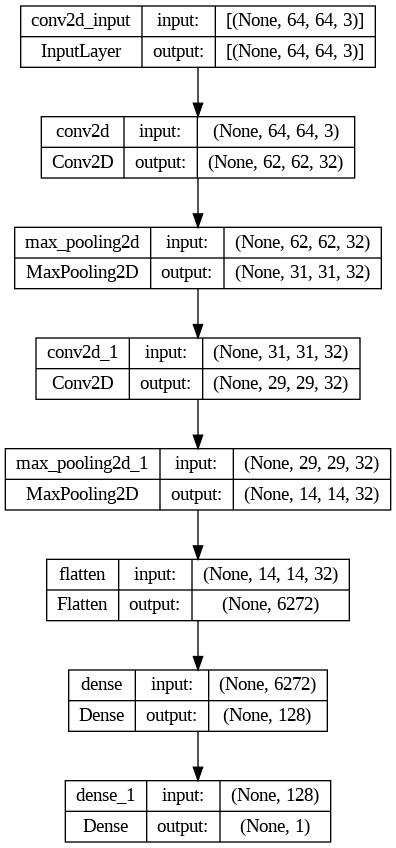

In [39]:
#plot png image for how model works

plot_model(model, to_file='model_plot_CNN.png', show_shapes=True, show_layer_names=True)

In [43]:
from google.colab import files
uploaded = files.upload()

Saving with_mask_1153.jpg to with_mask_1153.jpg


In [46]:
# Part 3 - Making new predictions

import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('with_mask_1153.jpg', target_size = (64, 64))
test_image1 = image.img_to_array(test_image)
test_image1 = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image1)
print(result)
#training_set.class_indices
if result[0][0] == 1:
    prediction = 'Person is without Mask'
    print(prediction)
else:
    prediction = 'Person is with mask'
    print(prediction)


1/1 [==============================] - 0s 19ms/step
[[0.]]
Person is with mask


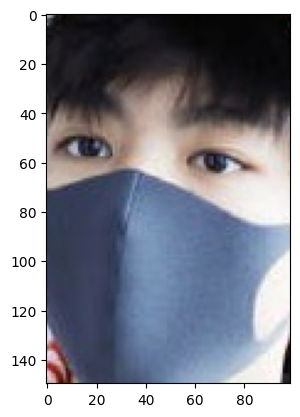

Model prediction : Person is with mask


In [47]:
# plot withmask vs witoth mask dataset
# load image pixels
image = imread('with_mask_1153.jpg')
# plot raw pixel data
pyplot.imshow(image)
# show the figure
pyplot.show()

print("Model prediction :", prediction)

In [48]:
!pip install gTTS

In [49]:
 #IPython provides a rich architecture for interactive computing
from gtts import gTTS
import IPython
#tts=gTTS(translation[0], lang='hi')
tts=gTTS(prediction)
tts.save('demo.wav')
sound_file='demo.wav'
IPython.display.Audio(sound_file, autoplay=True)

In [50]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/FDPCNN1.h5')
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(test_set)
print('test loss, test acc:', results)


# Evaluate on test data
48/48 [==============================] - 3s 67ms/step - loss: 0.1668 - accuracy: 0.9431
test loss, test acc: [0.16675667464733124, 0.9430840611457825]


In [51]:

test_set.reset
ytesthat = model.predict_generator(test_set)
print(ytesthat)
df = pd.DataFrame({
    'filename':test_set.filenames,
    'predict':ytesthat[:,0],
    'y':test_set.classes
})

<ipython-input-51-560c03a64373>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  ytesthat = model.predict_generator(test_set)


[[0.5513611 ]
 [0.99300295]
 [0.00338071]
 ...
 [0.99714774]
 [0.9979068 ]
 [0.00694875]]


In [52]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)
df


,filename,predict,y,y_pred
0,with_mask/with_mask_1001.jpg,0.6,0,1
1,with_mask/with_mask_1006.jpg,1.0,0,1
2,with_mask/with_mask_1009.jpg,0.0,0,0
3,with_mask/with_mask_1011.jpg,0.0,0,0
4,with_mask/with_mask_1013.jpg,1.0,0,1
...,...,...,...,...
1506,without_mask/without_mask_983.jpg,0.7,1,1
1507,without_mask/without_mask_987.jpg,0.0,1,0
1508,without_mask/without_mask_989.jpg,1.0,1,1
1509,without_mask/without_mask_993.jpg,1.0,1,1


In [53]:
#Check misclassified  images
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image : %d'%misclassified['y'].count())

Total misclassified image : 780


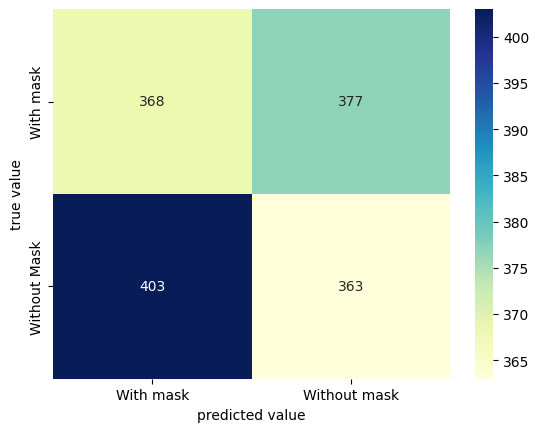

In [54]:
#Prediction of test set

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g', xticklabels=['With mask', 'Without mask'], yticklabels=['With mask', 'Without Mask'] );
plt.xlabel('predicted value')
plt.ylabel('true value');

1/1 [==============================] - 0s 67ms/step


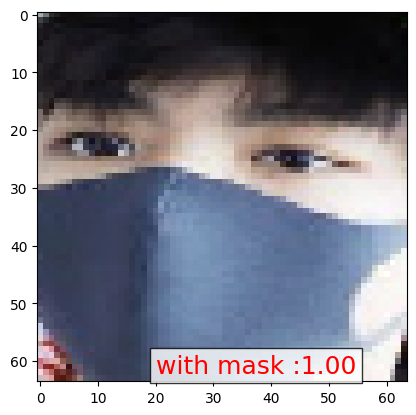

In [55]:
#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('with_mask_1153.jpg', target_size=(64, 64))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0 )
prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='withot mask %1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
else:
    value ='with mask :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))

plt.imshow(img1)
plt.show()

In [56]:
model_layers = [ layer.name for layer in model.layers]
print('layer name : ',model_layers)

layer name :  ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'flatten', 'dense', 'dense_1']


In [57]:
%%capture
# Model Accuracy
x1 = model.evaluate_generator(training_set)
x2 = model.evaluate_generator(test_set)




In [58]:
print('Training Accuracy  : %1.2f%%     Training loss  : %1.2f'%(x1[1]*100,x1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.2f'%(x2[1]*100,x2[0]))

Training Accuracy  : 96.13%     Training loss  : 0.10
Validation Accuracy: 94.31%     Validation loss: 0.17


In [59]:
#check model fitting
if x1[1]>x2[1]:
  print("Overfitting")
elif x2[1]>x1[1]:
  print("Underfitting")
else:
  print(" Model is perfect")

Overfirring


In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
!pip install streamlit==1.1.0

In [70]:
!pip install pyngrok==5.2.1

In [71]:
!ngrok authtoken  2SbNrOWeaQ9nfvVNC6UL8HYfFpu_6acwWo5SRxAmYm9tDGHyn

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [72]:
%%writefile app.py
import streamlit as st
from PIL import Image
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.preprocessing import image
import os
from werkzeug.utils import secure_filename
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
st.set_option('deprecation.showfileUploaderEncoding', False)
# Loading saved model from Drive.
from keras.models import load_model
model = load_model('/content/drive/My Drive/FDPCNN1.h5')

html_temp = """
   <div class="" style="background-color:blue;" >
   <div class="clearfix">
   <div class="col-md-12">
   <center><p style="font-size:40px;color:white;margin-top:10px;">face mask </p></center>
   <center><p style="font-size:30px;color:white;margin-top:10px;">Detection</p></center>
   </div>
   </div>
   </div>
   """
st.markdown(html_temp,unsafe_allow_html=True)

st.title("""
        Face Mask Detection
         """
         )
file= st.file_uploader("Please upload image", type=("jpeg", "png","jpg"))

import cv2
from  PIL import Image, ImageOps
def import_and_predict(image_data):
  #x = cv2.resize(image_data, (48, 48))
  #img = image.load_img(image_data, target_size=(48, 48))
  #x = image.img_to_array(img)
  size=(64, 64)
  image=ImageOps.fit(image_data, size, Image.ANTIALIAS)
  img=np.asarray(image)
  img_reshape=np.expand_dims(img, axis=1)
  img_reshape=img[np.newaxis,...]
  result = model.predict(img_reshape)
  print(result)
  #training_set.class_indices
  if result[0][0] == 1:
    prediction = "Person without Mask"
    print(prediction)
  else:
    prediction = 'Person  with Mask'
    print(prediction)#x = np.expand_dims(x, axis=1)


  return prediction
if file is None:
  st.text("Please upload an Image of person ")
else:
  image=Image.open(file)
  #image=np.array(image)
  #file_bytes = np.asarray(bytearray(file.read()), dtype=np.uint8)
  #image = cv2.imdecode(file_bytes, 1)
  st.image(image,caption='Uploaded Image.', use_column_width=True)

if st.button("Predict whether Person is with Mask or without Mask"):
  result=import_and_predict(image)
  st.success('Model has predicted the image  is  of  {}'.format(result))
if st.button("About"):
  st.header(" Deepak Moud")
  st.subheader("CNN Trainer")

html_temp = """
   <div class="" style="background-color:orange;" >
   <div class="clearfix">
   <div class="col-md-12">
   <center><p style="font-size:20px;color:white;margin-top:10px;">Model Developed using CNN</p></center>
   </div>
   </div>
   </div>
   """
st.markdown(html_temp,unsafe_allow_html=True)

Overwriting app.py


In [73]:
#!nohup streamlit run app.py &

In [76]:
from pyngrok import ngrok
url=ngrok.connect(port='8050')
url

<NgrokTunnel: "http://7461-34-124-154-95.ngrok-free.app" -> "http://localhost:80">

In [75]:
!streamlit run --server.port 80 app.py


2023-07-15 10:28:45.982 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:80
  External URL: http://34.124.154.95:80

2023-07-15 10:28:49.097093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-15 10:28:52.331662: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
  Stopping...
  Stopping...


In [ ]:
!ngrok.kill()